<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [1]:
import tensorflow as tf
import pandas as pd

csv_headers = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'gender', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income_bracket'
]
numeric_headers = ['capital_gain', 'capital_loss', 'hours_per_week']
target_header = 'income_bracket'

file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
df_train = pd.read_csv(tf.keras.utils.get_file(origin=file), header=None,
    names=csv_headers)
df_train.drop(columns=['fnlwgt', 'education_num'], inplace=True)
df_train['age'] = df_train['age'].astype(int)
for name in numeric_headers:
    df_train[name] = df_train[name].astype('float32')
X_train, y_train = df_train, df_train.pop(target_header)

file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
df_test = pd.read_csv(tf.keras.utils.get_file(origin=file), header=None,
    names=csv_headers)
df_test.drop(columns=['fnlwgt', 'education_num'], inplace=True)
df_test = df_test[1:].copy()
df_test['income_bracket'] = df_test['income_bracket'].apply(
    lambda x: x.replace('.', ''))
df_test['age'] = df_test['age'].astype(int)
for name in numeric_headers:
    df_test[name] = df_test[name].astype('float32')
X_test, y_test = df_test, df_test.pop(target_header)

In [2]:
import tensorflow as tf

inputs = {}
for name, column in X_train.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = dtype

    inputs[name] = tf.keras.Input(name=name, shape=[1,], dtype=dtype)

numeric_inputs = {name: input for name, input in inputs.items() if input.dtype=='float32'}
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(data=X_train[numeric_inputs.keys()].values)
numeric_features = tf.keras.layers.Concatenate(axis=-1)(list(numeric_inputs.values()))
numeric_features = normalizer(numeric_features)

# category_inputs = {

(None, 3)

In [ ]:
import tensorflow as tf

target_lookup = tf.keras.layers.StringLookup(output_mode='int',
    num_oov_indices=0, vocabulary=sorted(y_train.unique()))

def get_dataset(X, y, shuffle=False):
    X = {k: v.values[:, tf.newaxis] for k, v in X.items()}
    y = {y.name: target_lookup(y.values[:, tf.newaxis])}
    ds = tf.data.Dataset.from_tensor_slices(tensors=(X, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_dataset(X=X_train, y=y_train, shuffle=True)
ds_test = get_dataset(X=X_test, y=y_test)

In [ ]:
import tensorflow as tf
import keras

inputs, numeric_features, category_features = {}, [], []
for name, spec in ds_train.element_spec[0].items():
    if spec.dtype==tf.float32:
        inputs[name] = tf.keras.Input(name=name, shape=[1,], dtype=tf.float32)
        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(data=ds_train.map(lambda x, _: x[name]))
        numeric_features.append(normalizer(inputs[name]))
    else:
        if spec.dtype==tf.string:
            inputs[name] = tf.keras.Input(name=name, shape=[1,], dtype=tf.string)
            lookup = tf.keras.layers.StringLookup(output_mode='int')
            lookup.adapt(data=ds_train.map(lambda x, _: x[name]))
        else:
            inputs[name] = tf.keras.Input(name=name, shape=[1,], dtype=tf.int64)
            lookup = tf.keras.layers.IntegerLookup(output_mode='int')
            lookup.adapt(data=ds_train.map(lambda x, _: x[name]))
        embedding = tf.keras.Sequential(layers=[
            lookup,
            tf.keras.layers.Embedding(input_dim=lookup.vocabulary_size(),
                output_dim=4)
        ])
        category_features.append(embedding(inputs[name]))

numeric_features = tf.keras.ops.stack(x=numeric_features, axis=1)
category_features = tf.keras.ops.stack(x=category_features, axis=1)
numeric_features.shape, category_features.shape

((None, 3, 1), (None, 9, 1, 4))

In [ ]:
import tensorflow as tf

inputs = {}
for name, column in X_train.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = dtype

    inputs[name] = tf.keras.Input(name=name, shape=[1,], dtype=dtype)

numeric_inputs = {n: i for n, i in inputs.items() if i.dtype==tf.float32}
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(data=X_train[numeric_inputs.keys()].values)
numeric_inputs = keras.layers.Concatenate(axis=-1)(list(numeric_inputs.values()))
numeric_features = normalizer(numeric_inputs)
numeric_features = keras.layers.LayerNormalization()(numeric_features)
numeric_features.shape

(None, 3)

In [ ]:
category_inputs = {n: i for n, i in inputs.items() if i.dtype!=tf.float32}
category_features = []
for n, i in category_inputs.items():
    vocab = sorted(set(X_train[n]))
    if i.dtype==tf.string:
        lookup = keras.layers.StringLookup(vocabulary=vocab, output_mode='int')
    else:
        lookup = keras.layers.IntegerLookup(vocabulary=vocab, output_mode='int')
    embedding = keras.Sequential(layers=[
        lookup,
        keras.layers.Embedding(input_dim=lookup.vocabulary_size(),
            output_dim=4)
    ])
    category_features.append(embedding(i))
# category_features = keras.layers.Concatenate(axis=-1)(category_features)
category_features = keras.ops.stack(category_features, axis=1)
category_features.shape

(None, 9, 1, 4)

In [ ]:
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def df_to_ds(df, shuffle=False):
    x = {k: v.values[:, tf.newaxis] for k, v in df.items()}
    y = {"target": x.pop("target"), "thalach": x.pop("thalach")}
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size=64).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = df_to_ds(df=df_train, shuffle=True)
ds_test = df_to_ds(df=df_test, shuffle=False)

inputs = {}
for name, spec in ds_train.element_spec[0].items():
    inputs[name] = tf_keras.Input(name=name, shape=(1,), dtype=spec.dtype)

features = []
for name in ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]:
    dtype = ds_train.element_spec[0][name].dtype
    if dtype=="string":
        lookup = tf_keras.layers.StringLookup(output_mode="int")
    else:
        lookup = tf_keras.layers.IntegerLookup(output_mode="int")
    lookup.adapt(data=ds_train.map(lambda x, _: x[name]))
    embedding = tf_keras.Sequential(layers=[
        lookup,
        tf_keras.layers.Embedding(input_dim=lookup.vocabulary_size(),
            output_dim=round(lookup.vocabulary_size()/2)),
        tf_keras.layers.Flatten()
    ])
    features.append(embedding(inputs[name]))

for name in ["age", "trestbps", "chol", "oldpeak"]:
    normalizer = tf_keras.layers.Normalization(axis=None)
    normalizer.adapt(data=ds_train.map(lambda x, _: x[name]))
    features.append(normalizer(inputs[name]))

features = tf_keras.layers.Concatenate(axis=-1)(features)

net = tf_keras.Sequential(layers=[
    tf_keras.layers.Dense(units=32, activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)),
    tf_keras.layers.Dropout(rate=0.2),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)),
    tf_keras.layers.Dropout(rate=0.2)
])

h = net(inputs=features)
h_thalach = tf_keras.layers.Dense(units=tfp.layers.IndependentNormal\
    .params_size(event_shape=(1,)))(inputs=h)

outputs = {
    "target": tf_keras.layers.Dense(name="target", units=1,
        activation=tf.keras.activations.sigmoid)(inputs=h),
    # "thalach": tf.keras.layers.Dense(name="thalach", units=1,
    #     activation=tf.keras.activations.linear)(inputs=h)
    "thalach": tfp.layers.IndependentNormal(name="thalach",
        event_shape=(1,), convert_to_tensor_fn=tfp.distributions\
        .Distribution.sample)(inputs=h_thalach)
}

model = tf_keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss = {
        "target": tf.keras.losses.BinaryCrossentropy(),
        # "thalach": tf.keras.losses.MeanSquaredError()
        "thalach": lambda y_true, y_pred: -y_pred.log_prob(value=y_true)
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = {
        "target": [
            tf.keras.metrics.BinaryAccuracy(name="acc")
        ],
        "thalach": [
            tf.keras.metrics.MeanAbsoluteError(name="mae")
        ]
    }
)

# os.makedirs("models", exist_ok=True)
# ckptPath = "models/training.weights.h5"
# ckptSave = tf.keras.callbacks.ModelCheckpoint(monitor="val_loss",
#     mode="min", save_best_only=True, save_weights_only=True,
#     filepath=ckptPath)
# reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",
#     mode="min", patience=5, factor=0.9)

# history = model.fit(x=ds_train, validation_data=ds_test, epochs=100,
#     callbacks=[ckptSave, reduceLR], verbose=False)
# df_history = pd.DataFrame(history.history)
# df_history["epoch"] = df_history.index + 1

# fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(9, 9))
# fig.suptitle(t="Training Metrics")
# axes[0].set_title(label="loss vs.epoch")
# axes[0].set_ylabel(ylabel="loss")
# for l in ["target", "thalach"]:
#     sns.lineplot(ax=axes[0], label=f"{l}_loss", data=df_history,
#         x="epoch", y=f"{l}_loss")
#     sns.lineplot(ax=axes[0], label=f"val_{l}_loss", data=df_history,
#         x="epoch", y=f"val_{l}_loss")
# axes[0].legend(loc="best")

# for ax, m in zip(axes[1:], ["target_acc", "thalach_mae"]):
#     ax.set_title(label=f"{m} vs.epoch")
#     ax.set_ylabel(ylabel=m)
#     sns.lineplot(ax=ax, label=m, data=df_history,
#         x="epoch", y=m)
#     sns.lineplot(ax=ax, label=f"val_{m}", data=df_history,
#         x="epoch", y=f"val_{m}")
#     ax.legend(loc="best")

# axes[2].set_xlabel(xlabel="epoch")
# fig.tight_layout()
# fig.show()

# model.load_weights(ckptPath)
# print("Test result:")
# model.evaluate(x=ds_test, return_dict=True, verbose=False)

In [ ]:
import tensorflow as tf

x_sample = {k: v.values[:, tf.newaxis] for k, v in df_test[0::10].items()}
y_sample = {"target": x_sample.pop("target"),
    "thalach": x_sample.pop("thalach")}
y_pred = model(inputs=x_sample)

target_true = target_encoder.inverse_transform(
    y=y_sample["target"].squeeze())
target_pred = tf.cast(y_pred["target"] > 0.5, tf.int64)
target_pred = target_encoder.inverse_transform(
    y=tf.squeeze(target_pred))
acc = tf.keras.metrics.BinaryAccuracy()(
    y_true=target_true, y_pred=target_pred)
print("target accuracy:", acc)

thalach_true = thalach_scaler.inverse_transform(
    X=y_sample["thalach"])
thalach_pred = thalach_scaler.inverse_transform(
    X=y_pred["thalach"])
mae = tf.keras.metrics.MeanAbsoluteError()(
    y_true=thalach_true, y_pred=thalach_pred)
print("thalach mae:", mae)

target accuracy: tf.Tensor(0.90909094, shape=(), dtype=float32)
thalach mae: tf.Tensor(6.954035, shape=(), dtype=float32)


## Customize training

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


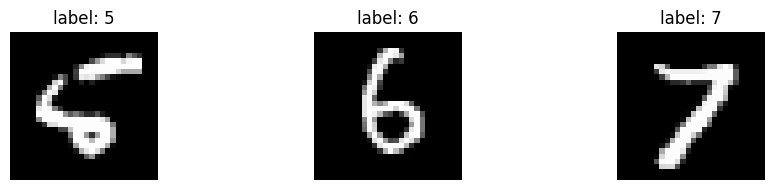

(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
fig, axes =  plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
for ax, x, y in zip(axes, x_plt, y_plt):
    ax.set_title(label=f"label: {y}")
    ax.imshow(X=x, cmap="gray")
    ax.axis("off")
fig.tight_layout()
plt.show()

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

Training duration: 52s


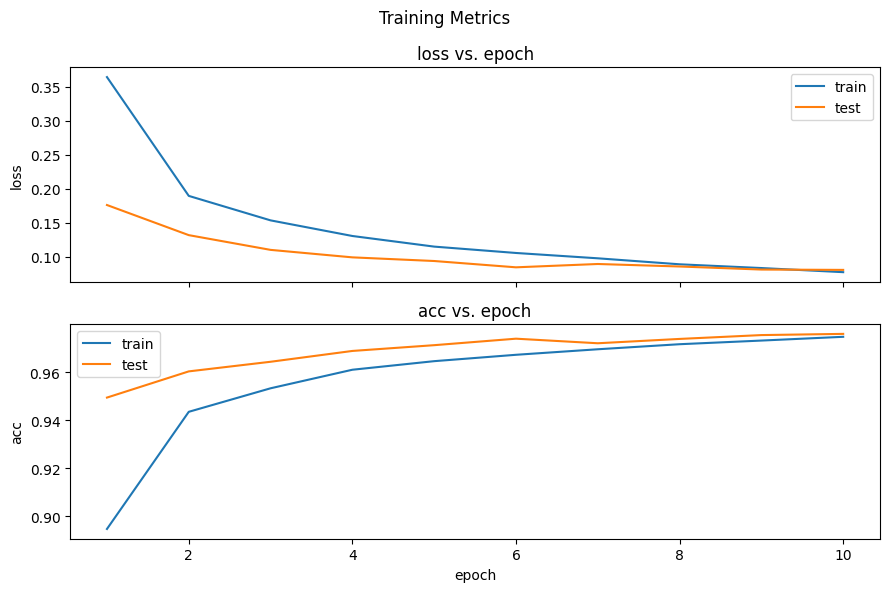

In [ ]:
import keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

@keras.saving.register_keras_serializable()
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.preprocess = tf.keras.Sequential(layers=[
            tf.keras.layers.Rescaling(scale=1./255),
            tf.keras.layers.Reshape(target_shape=(784,))
        ])

    @tf.function
    def call(self, inputs):
        return self.preprocess(inputs=inputs)

x = tf.keras.Input(name="Images", shape=(28, 28), dtype=tf.float32)
h = PreprocessingLayer(name="preprocessing")(inputs=x)
h = tf.keras.layers.Dense(units=64,
    activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs=h)
h = tf.keras.layers.Dropout(rate=0.2)(inputs=h)
y = tf.keras.layers.Dense(units=10,
    activation=tf.keras.activations.softmax)(inputs=h)
model = tf.keras.Model(inputs=x, outputs=y)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [
    tf.keras.metrics.Mean(name="loss"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="acc")
]

os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="test_acc",
    mode="max", save_best_only=True, save_weights_only=True, filepath=ckptPath)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    mode="min", patience=1, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=model, add_history=True,
    callbacks=[ckptModel, reduceLR])

@tf.function(reduce_retracing=True)
def train_step(data):
    x, y = data
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = loss_fn(y_true=y, y_pred=y_pred)
    vars = model.trainable_variables
    grads = tape.gradient(target=loss, sources=vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(grads, vars))
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"train_{m.name}": m.result() for m in metrics}

@tf.function(reduce_retracing=True)
def test_step(data):
    x, y = data
    y_pred = model(inputs=x, training=False)
    loss = loss_fn(y_true=y, y_pred=y_pred)
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"test_{m.name}": m.result() for m in metrics}

start_time = time.time()
history, logs = [], {}
callbacks.on_train_begin(logs=logs)
for epoch in range(10):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for data in ds_train:
        logs = train_step(data=data)
    for m in metrics:
        m.reset_state()

    for data in ds_test:
        logs_test = test_step(data=data)
    logs.update(logs_test)
    for m in metrics:
        m.reset_state()

    callbacks.on_epoch_end(epoch=epoch, logs=logs)
    history.append({k: v.numpy() for k, v in logs.items()})
callbacks.on_train_end(logs=logs)
print("Training duration: %2.fs"%(time.time() - start_time))

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 6))
fig.suptitle(t="Training Metrics")
for ax, m in zip(axes, metrics):
    ax.set_title(label=f"{m.name} vs. epoch")
    ax.set_ylabel(ylabel=m.name)
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=f"train_{m.name}")
    sns.lineplot(ax=ax, label="test", data=df_history,
        x="epoch", y=f"test_{m.name}")
    ax.legend(loc="best")
axes[1].set_xlabel(xlabel="epoch")
fig.tight_layout()
fig.show()

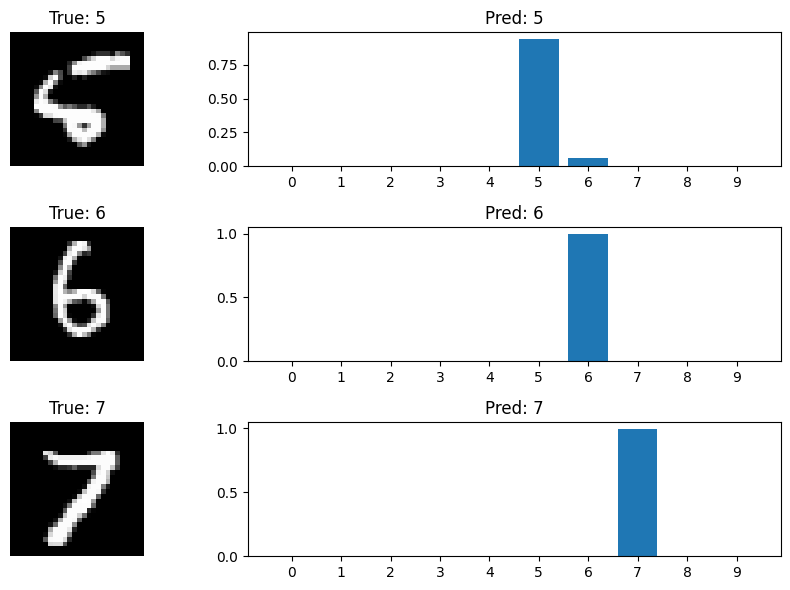

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
model.load_weights(ckptPath)
probs = model(inputs=x_plt)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)
for ax, x, y, prob in zip(axes, x_plt, y_plt, probs):
    ax[0].set_title(label=f"True: {y}")
    ax[0].imshow(X=x, cmap="gray")
    ax[0].axis("off")
    ax[1].set_title(label=f"Pred: {tf.math.argmax(input=prob)}")
    ax[1].bar(x=np.arange(len(prob)), height=prob)
    ax[1].set_xticks(ticks=np.arange(len(prob)))
fig.tight_layout()
plt.show()